## Features extraction

Convert audio_file.ma4 from voice memo to audio_file.wav

In [1]:
"""
!pip install pydub
import os
from pydub import AudioSegment
from glob import glob

from google.colab import drive
drive.mount('/content/drive')
# Set up input and output directories
input_base_dir = '/content/drive/MyDrive/speech'
output_base_dir = '/content/drive/MyDrive/speech_wav'  # Output to this new directory

# Create output base directory if not exists
os.makedirs(output_base_dir, exist_ok=True)

# Loop over all folders in the base directory
for folder_name in os.listdir(input_base_dir):
    folder_path = os.path.join(input_base_dir, folder_name)
    if os.path.isdir(folder_path):
        # Create corresponding output folder
        output_folder = os.path.join(output_base_dir, folder_name)
        os.makedirs(output_folder, exist_ok=True)

        # Process all .m4a files in the folder
        for m4a_file in glob(os.path.join(folder_path, "*.m4a")):
            filename = os.path.basename(m4a_file).replace(".m4a", ".wav")
            output_file = os.path.join(output_folder, filename)

            # Convert using pydub
            audio = AudioSegment.from_file(m4a_file, format="m4a")
            audio.export(output_file, format="wav")

            print(f"Converted: {m4a_file} → {output_file}")
"""

Mounted at /content/drive
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_1.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_1.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_7.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_7.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_8.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_8.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_4.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_4.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_2.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_2.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_3.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_3.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_5.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_5.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_9.m4a → /content/drive/MyDrive/speech_wav/IWTGH/IWTGH_9.wav
Converted: /content/drive/MyDrive/speech/IWTGH/IWTGH_10.m4a → /content

In [20]:
import os
import librosa as lb
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Root folder path containing subfolders with .wav files
root_path = "/content/drive/MyDrive/speech_wav/audio"
features_data = []

# Loop through each subfolder
for folder_name in os.listdir(root_path):
    folder_path = os.path.join(root_path, folder_name)

    if not os.path.isdir(folder_path):
        continue

    for item in tqdm(os.listdir(folder_path), desc=f"Processing {folder_name}"):
        if not item.endswith(".wav"):
            continue

        item_path = os.path.join(folder_path, item)
        fileName = f"{folder_name}/{item.replace('.wav', '')}"

        try:
            y, sr = lb.load(item_path, sr=None)
            n_fft = 1024

            # Pad signal to minimum length
            if len(y) < n_fft:
                y = np.pad(y, (0, n_fft - len(y)))

            result = np.array([])

            # Compute spectrogram for some features
            S = np.abs(lb.stft(y, n_fft=n_fft))

            # Feature extraction
            mfcc = np.mean(lb.feature.mfcc(y=y, sr=sr, n_fft=n_fft).T, axis=0)
            mel = np.mean(lb.feature.melspectrogram(y=y, sr=sr).T, axis=0)
            chroma = np.mean(lb.feature.chroma_stft(S=S, sr=sr, n_fft=n_fft).T, axis=0)
            contrast = np.mean(lb.feature.spectral_contrast(S=S, sr=sr, n_fft=n_fft).T, axis=0)

            # Tonnetz requires harmonic audio
            h = lb.effects.harmonic(y)
            if len(h) < n_fft:
                h = np.pad(h, (0, n_fft - len(h)))
            tonnetz = np.mean(lb.feature.tonnetz(y=h, sr=sr).T, axis=0)

            # Combine all features
            result = np.hstack((mfcc, mel, chroma, contrast, tonnetz))
            features_data.append([fileName, *result])

        except Exception as e:
            print(f"Error processing {fileName}: {e}")

# Define feature column names
mfcc_cols = [f"mfcc_{i+1}" for i in range(len(mfcc))]
mel_cols = [f"mel_{i+1}" for i in range(len(mel))]
chroma_cols = [f"chroma_{i+1}" for i in range(len(chroma))]
contrast_cols = [f"spect_{i+1}" for i in range(len(contrast))]
tonnetz_cols = [f"tonnetz_{i+1}" for i in range(len(tonnetz))]

all_columns = ["audio"] + mfcc_cols + mel_cols + chroma_cols + contrast_cols + tonnetz_cols

# Create the final features DataFrame
features_df = pd.DataFrame(features_data, columns=all_columns)
print("Feature extraction complete. Shape:", features_df.shape)
features_df.head()

Processing TBMBW: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]

Feature extraction complete. Shape: (180, 174)


,audio,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,spect_4,spect_5,spect_6,spect_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,IWTGH/IWTGH_1,-456.161011,173.850739,-0.445930,43.220448,-2.208230,5.250477,2.358801,16.227489,4.849324,...,12.345949,13.214580,16.673017,31.776100,0.028255,-0.018589,0.115786,-0.013089,-0.031850,-0.050886
1,IWTGH/IWTGH_7,-395.242798,171.847427,0.371300,34.765068,-2.505120,14.977810,-3.485596,1.698898,-0.775851,...,12.642402,14.346615,17.441942,34.994604,-0.025708,-0.027114,0.042067,-0.113314,0.005059,-0.014681
2,IWTGH/IWTGH_8,-385.991058,164.279984,-10.153129,42.339943,-1.909930,2.025210,0.001517,1.005306,0.368697,...,12.748602,13.694660,16.364253,36.140007,0.021706,-0.019084,0.152820,-0.025098,-0.027136,-0.037164
3,IWTGH/IWTGH_4,-460.136444,171.376282,-0.733322,44.148335,-5.689566,9.734161,-3.116978,13.025571,3.540501,...,12.829127,13.194763,17.238967,32.216306,0.008253,-0.017944,0.081751,-0.002341,-0.019149,-0.016467
4,IWTGH/IWTGH_2,-403.748169,158.715408,10.692320,27.654495,1.954888,2.280664,0.531536,9.434690,6.756381,...,12.661829,13.684149,17.276580,33.785295,0.000486,0.028319,0.064798,-0.031453,0.001535,-0.017270


In [41]:
import re

# clean up columns
def normalize_col(col):
    # Lowercase, remove special characters, unify formats like mfcc[1], MFCC_1, mfcc1
    col = col.lower()
    col = re.sub(r"[\[\]\(\)\-]", "_", col)
    col = re.sub(r"[^a-z0-9_]", "", col)
    col = re.sub(r"mfcc[_]?(\d+)", r"mfcc_\1", col)
    col = re.sub(r"mel[_]?(\d+)", r"mel_\1", col)
    col = re.sub(r"chroma[_]?(\d+)", r"chroma_\1", col)
    col = re.sub(r"spect[_]?(\d+)", r"spect_\1", col)
    col = re.sub(r"tonnetz[_]?(\d+)", r"tonnetz_\1", col)
    return col.strip()

# Normalize column names to detect semantic duplicates
normalized_cols = {col: normalize_col(col) for col in features_df.columns}

# Map normalized -> original
norm_to_original = {}
for original, norm in normalized_cols.items():
    if norm not in norm_to_original:
        norm_to_original[norm] = original

# Keep only one version of each semantic feature
features_df = features_df[norm_to_original.values()]

# Rename to cleaned, consistent names
features_df.columns = list(norm_to_original.keys())

# View features
print("Cleaned and deduplicated columns:")
print(features_df.columns.tolist())

features_df.head()

Cleaned and deduplicated columns:
['clipname', 'transcript', 'group', 'word', 'tone', 'indicator', 'type', 'sentence', 'word_count', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mel_1', 'mel_2', 'mel_3', 'mel_4', 'mel_5', 'mel_6', 'mel_7', 'mel_8', 'mel_9', 'mel_10', 'mel_11', 'mel_12', 'mel_13', 'mel_14', 'mel_15', 'mel_16', 'mel_17', 'mel_18', 'mel_19', 'mel_20', 'mel_21', 'mel_22', 'mel_23', 'mel_24', 'mel_25', 'mel_26', 'mel_27', 'mel_28', 'mel_29', 'mel_30', 'mel_31', 'mel_32', 'mel_33', 'mel_34', 'mel_35', 'mel_36', 'mel_37', 'mel_38', 'mel_39', 'mel_40', 'mel_41', 'mel_42', 'mel_43', 'mel_44', 'mel_45', 'mel_46', 'mel_47', 'mel_48', 'mel_49', 'mel_50', 'mel_51', 'mel_52', 'mel_53', 'mel_54', 'mel_55', 'mel_56', 'mel_57', 'mel_58', 'mel_59', 'mel_60', 'mel_61', 'mel_62', 'mel_63', 'mel_64', 'mel_65', 'mel_66', 'mel_

,clipname,transcript,group,word,tone,indicator,type,sentence,word_count,mfcc_1,...,spect_4,spect_5,spect_6,spect_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,IWTGH_1,I want to go home.,1,Neutral,Neutral,NaN,Statement,Single,18,-456.161011,...,12.345949,13.21458,16.673017,31.7761,0.028255,-0.018589,0.115786,-0.013089,-0.03185,-0.050886
1,IWTGH_2,I want to go home.,1,Neutral,Anger,NaN,Statement,Single,18,-403.748169,...,12.661829,13.684149,17.27658,33.785295,0.000486,0.028319,0.064798,-0.031453,0.001535,-0.01727
2,IWTGH_3,I want to go home.,1,Neutral,Disgust,NaN,Statement,Single,18,-455.887939,...,12.708105,13.574046,15.457117,33.037995,0.022056,-0.044555,0.114726,-0.004732,-0.040863,-0.023962
3,IWTGH_4,I want to go home.,1,Neutral,Fear,NaN,Statement,Single,18,-460.136444,...,12.829127,13.194763,17.238967,32.216306,0.008253,-0.017944,0.081751,-0.002341,-0.019149,-0.016467
4,IWTGH_5,I want to go home.,1,Neutral,Sad,NaN,Statement,Single,18,-432.942596,...,12.880225,13.12989,17.900985,31.293743,0.010412,-0.034611,0.111465,-0.05606,-0.061425,-0.03194


In [38]:
text_path = '/content/drive/MyDrive/speech_wav/text_sentences.xlsx'
text_df = pd.read_excel(text_path)
text_df.head()

,clipName,transcript,group,word,tone,indicator,type,sentence,word_count
0,IWTGH_1,I want to go home.,1,Neutral,Neutral,NaN,Statement,Single,18
1,IWTGH_2,I want to go home.,1,Neutral,Anger,NaN,Statement,Single,18
2,IWTGH_3,I want to go home.,1,Neutral,Disgust,NaN,Statement,Single,18
3,IWTGH_4,I want to go home.,1,Neutral,Fear,NaN,Statement,Single,18
4,IWTGH_5,I want to go home.,1,Neutral,Sad,NaN,Statement,Single,18


In [43]:
# Merge features_df to the original text_sentences
merged_df = pd.merge(text_df, features_df, left_on='clipName', right_on='clipname', how='inner')
merged_df.head()
features_df = merged_df

In [46]:
#  Remove exact duplicate columns (same content, different names)
def drop_duplicate_columns(df):
    df_T = df.T.drop_duplicates().T  # Transpose to treat columns as rows
    return df_T

# Rename columns to standard naming conventions
def rename_columns(df):
    df = df.copy()
    df.columns = [col.strip().lower().replace(" ", "_").replace("-", "_") for col in df.columns]
    return df

# Apply both functions
features_df = drop_duplicate_columns(features_df)
features_df = rename_columns(features_df)

features_df.rename(columns=lambda col: col.replace('_x', '') if col.endswith('_x') else col, inplace=True)

features_df.head()

,clipname,transcript,group,word,tone,indicator,type,sentence,word_count,mfcc_1,...,spect_4,spect_5,spect_6,spect_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,IWTGH_1,I want to go home.,1,Neutral,Neutral,NaN,Statement,Single,18,-456.161011,...,12.345949,13.21458,16.673017,31.7761,0.028255,-0.018589,0.115786,-0.013089,-0.03185,-0.050886
1,IWTGH_2,I want to go home.,1,Neutral,Anger,NaN,Statement,Single,18,-403.748169,...,12.661829,13.684149,17.27658,33.785295,0.000486,0.028319,0.064798,-0.031453,0.001535,-0.01727
2,IWTGH_3,I want to go home.,1,Neutral,Disgust,NaN,Statement,Single,18,-455.887939,...,12.708105,13.574046,15.457117,33.037995,0.022056,-0.044555,0.114726,-0.004732,-0.040863,-0.023962
3,IWTGH_4,I want to go home.,1,Neutral,Fear,NaN,Statement,Single,18,-460.136444,...,12.829127,13.194763,17.238967,32.216306,0.008253,-0.017944,0.081751,-0.002341,-0.019149,-0.016467
4,IWTGH_5,I want to go home.,1,Neutral,Sad,NaN,Statement,Single,18,-432.942596,...,12.880225,13.12989,17.900985,31.293743,0.010412,-0.034611,0.111465,-0.05606,-0.061425,-0.03194


In [47]:
# save a new file
features_df.to_csv('/content/drive/MyDrive/speech_wav/features.csv', index=False)

# Visualization

In [63]:
# Check all unique emotion labels in the 'tone' column
unique_tone_emotions = features_df['tone'].unique().tolist()
unique_tone_emotions

['Neutral', 'Anger', 'Disgust', 'Fear', 'Sad', 'Happy']

### **Mfcc: Mel-Frequency Cepstral Coefficients**

  Models human auditory perception

  Captures timbre, tone quality, and articulation of speech. Derived from log power spectrum on Mel scale.

  Low value: More dull, soft, or flat vocal quality — often linked to neutral or sad tone.

  High value: Bright, sharp, or tense vocal tone — may indicate anger, fear, or stress.

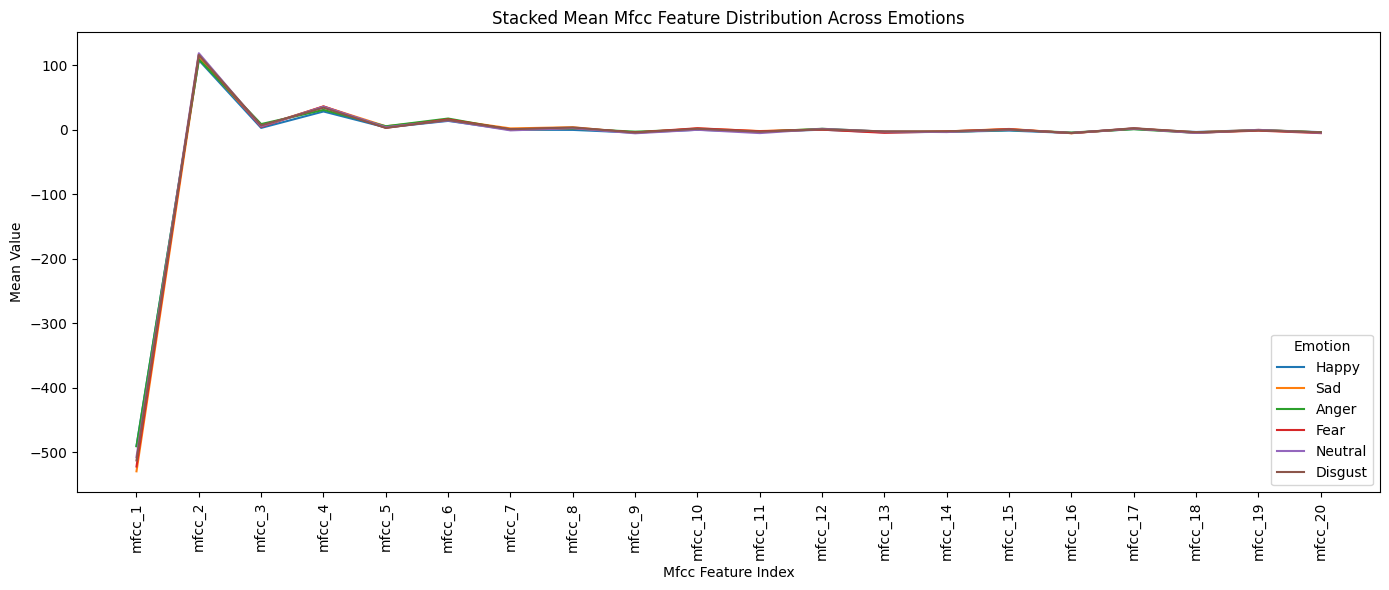

In [75]:
# Extract all mfcc feature columns
mfcc_cols = [col for col in features_df.columns if col.startswith('mfcc_')]

# Compute mean values for mfcc features per emotion
mfcc_means_by_emotion = features_df.groupby('tone')[mfcc_cols].mean()

# Filter to only include the 6 target emotions
mfcc_means_by_emotion = mfcc_means_by_emotion.loc[['Happy', 'Sad', 'Anger', 'Fear', 'Neutral', 'Disgust']]

# Plot stacked line chart
plt.figure(figsize=(14, 6))
for emotion in mfcc_means_by_emotion.index:
    plt.plot(mfcc_cols, mfcc_means_by_emotion.loc[emotion], label=emotion)

plt.title("Stacked Mean Mfcc Feature Distribution Across Emotions")
plt.xlabel("Mfcc Feature Index")
plt.ylabel("Mean Value")
plt.xticks(rotation=90)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

mfcc values appear almost the same for all emotions, so we cannot analyze much for this feature

### **Mel: 	Mel Spectrogram**

Energy across frequencies on the Mel scale

Shows intensity and frequency content of speech — rich in emotional cues.

Low value: Less energy, especially in high frequencies — common in sad, low arousal states.

High value: Higher energy, wide spectral spread — often found in angry or excited tones.

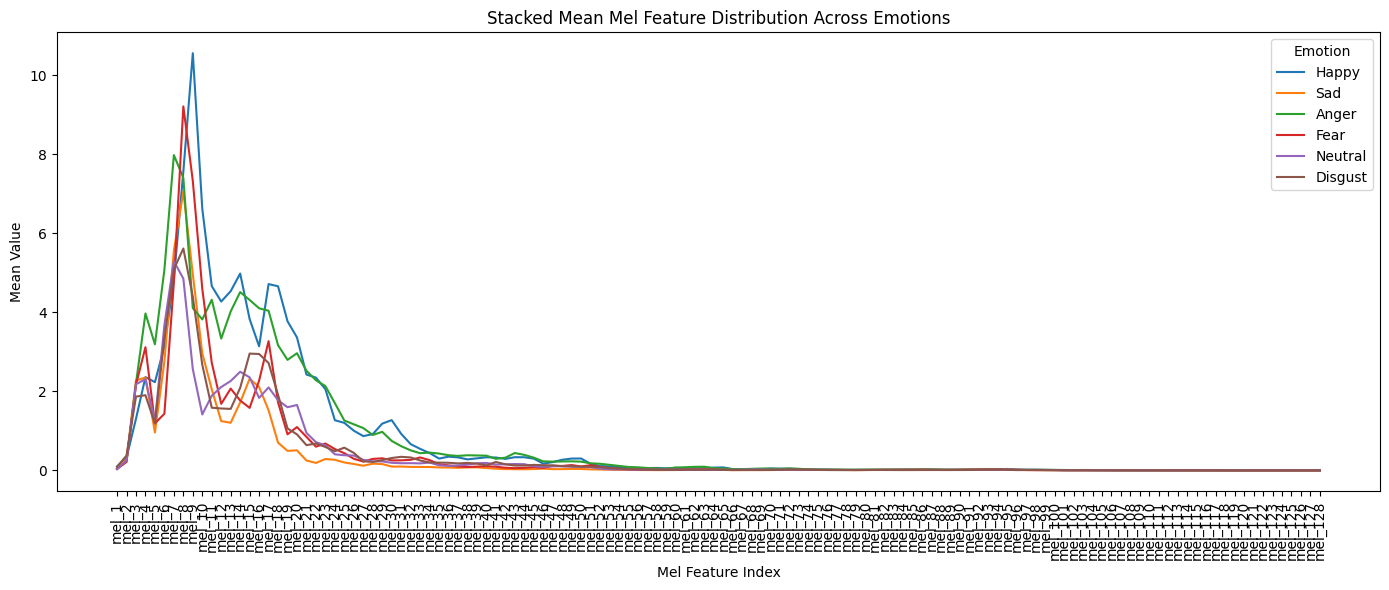

In [74]:
# Extract all mel feature columns
mel_cols = [col for col in features_df.columns if col.startswith('mel_')]

# Compute mean values for mel features per emotion
mel_means_by_emotion = features_df.groupby('tone')[mel_cols].mean()

# Filter to only include the 6 target emotions
mel_means_by_emotion = mel_means_by_emotion.loc[['Happy', 'Sad', 'Anger', 'Fear', 'Neutral', 'Disgust']]

# Plot stacked line chart
plt.figure(figsize=(14, 6))
for emotion in mel_means_by_emotion.index:
    plt.plot(mel_cols, mel_means_by_emotion.loc[emotion], label=emotion)

plt.title("Stacked Mean Mel Feature Distribution Across Emotions")
plt.xlabel("Mel Feature Index")
plt.ylabel("Mean Value")
plt.xticks(rotation=90)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

Anger shows a broad rise in mid to high frequencies, indicating strong vocal energy.

Fear is similarly high, but slightly more focused in the high-frequency range.

Sad has consistently low Mel energy, especially in high bands.

Happy has a smoother profile with lifted mid-frequencies.

Neutral and Disgust are flatter, with low dynamic energy.

### **Chroma: chroma frequency**

Energy across 12 pitch classes (musical scale)

Indicates pitch content; helps spot tonal patterns in speech.

Lower value: Less pitch activity — may reflect monotone or calm speech.

Higher value: More tonal variation — possibly emphatic, sarcastic, or musical in speech

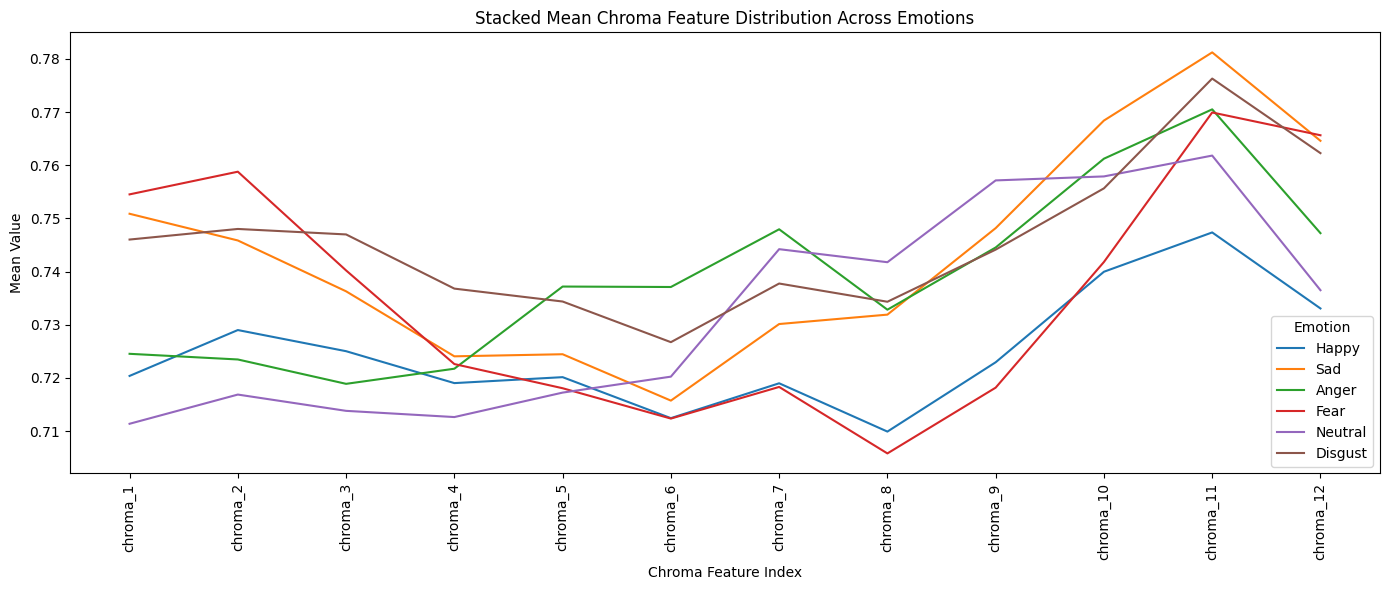

In [76]:
# Extract all chroma feature columns
chroma_cols = [col for col in features_df.columns if col.startswith('chroma_')]

# Compute mean values for chroma features per emotion
chroma_means_by_emotion = features_df.groupby('tone')[chroma_cols].mean()

# Filter to only include the 6 target emotions
chroma_means_by_emotion = chroma_means_by_emotion.loc[['Happy', 'Sad', 'Anger', 'Fear', 'Neutral', 'Disgust']]

# Plot stacked line chart
plt.figure(figsize=(14, 6))
for emotion in chroma_means_by_emotion.index:
    plt.plot(chroma_cols, chroma_means_by_emotion.loc[emotion], label=emotion)

plt.title("Stacked Mean Chroma Feature Distribution Across Emotions")
plt.xlabel("Chroma Feature Index")
plt.ylabel("Mean Value")
plt.xticks(rotation=90)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

Happy and Fear show the most pitch class variation, implying intonation or melodic qualities.

Anger has moderate chroma activity — emotionally charged but less musical.

Sad, Neutral, and Disgust display flatter chroma patterns, indicating monotone or low pitch movement.

### Spect: Spectral Contrast

Difference between spectral peaks and valleys

Measures timbre variability and sharpness of sound.

Lower value: Smoother, less contrast — can suggest low emotion, calm, or sadness.

Higher value: Sharper peaks — more expressive, tense, or harsh voice (e.g., anger).

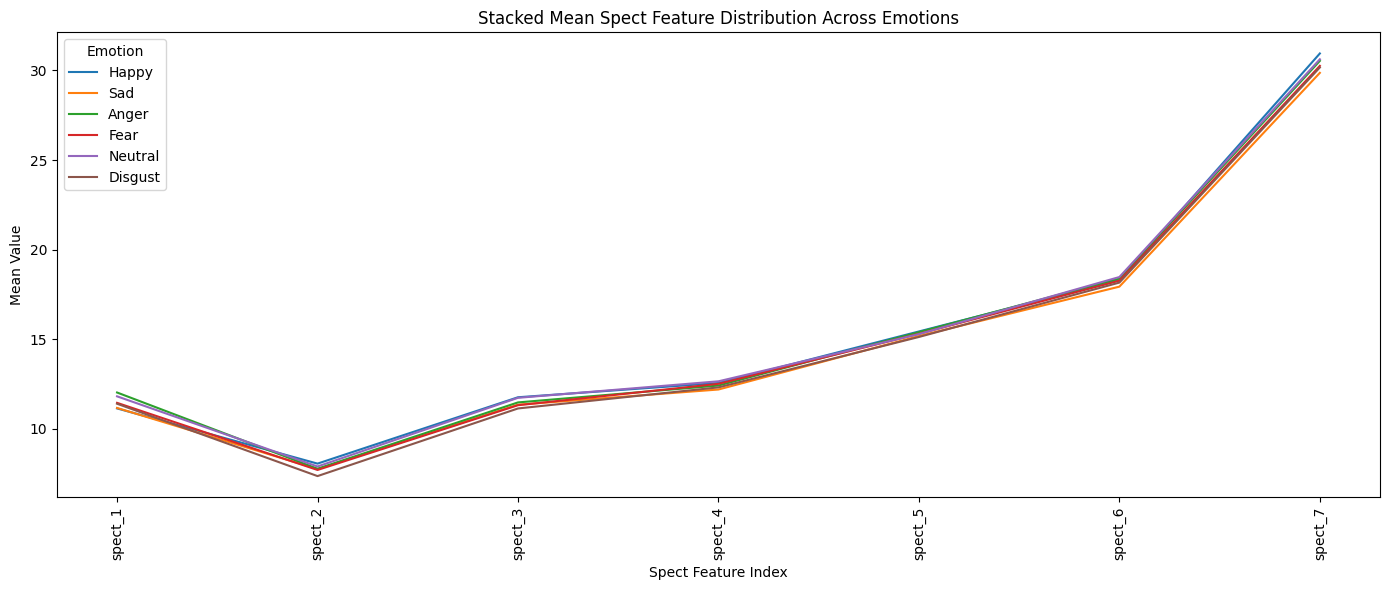

In [77]:
# Extract all spect feature columns
spect_cols = [col for col in features_df.columns if col.startswith('spect_')]

# Compute mean values for spect features per emotion
spect_means_by_emotion = features_df.groupby('tone')[spect_cols].mean()

# Filter to only include the 6 target emotions
spect_means_by_emotion = spect_means_by_emotion.loc[['Happy', 'Sad', 'Anger', 'Fear', 'Neutral', 'Disgust']]

# Plot stacked line chart
plt.figure(figsize=(14, 6))
for emotion in spect_means_by_emotion.index:
    plt.plot(spect_cols, spect_means_by_emotion.loc[emotion], label=emotion)

plt.title("Stacked Mean Spect Feature Distribution Across Emotions")
plt.xlabel("Spect Feature Index")
plt.ylabel("Mean Value")
plt.xticks(rotation=90)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

Anger has the highest spectral contrast, suggesting edgy, piercing delivery.

Fear is also elevated — chaotic vocal textures may be present.

Sad and Neutral show the lowest contrast — dull, soft, and even voice quality.

Happy sits in the middle, showing controlled energy.

Disgust fluctuates, hinting at instability or vocal irregularity.

### Tonnetz: Tonal Centroid Features

Harmonic and tonal relationships between pitches

Originally used for music, but helps capture tonal flow in speech.

Lower value: Tonally flat — less expressive or emotionally muted.

Higher value: More complex tonal dynamics — may reflect emotionally charged, sung, or lyrical speech.

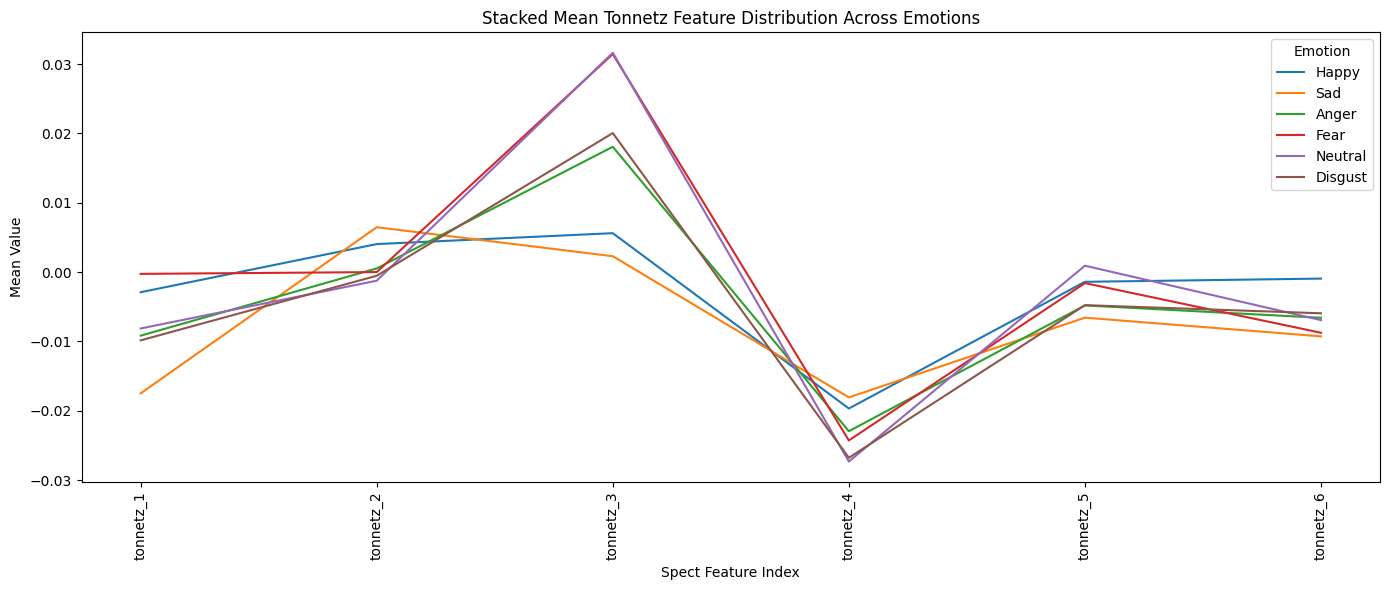

In [78]:
# Extract all tonnetz feature columns
tonnetz_cols = [col for col in features_df.columns if col.startswith('tonnetz_')]

# Compute mean values for mel features per emotion
tonnetz_means_by_emotion = features_df.groupby('tone')[tonnetz_cols].mean()

# Filter to only include the 6 target emotions
tonnetz_means_by_emotion = tonnetz_means_by_emotion.loc[['Happy', 'Sad', 'Anger', 'Fear', 'Neutral', 'Disgust']]

# Plot stacked line chart
plt.figure(figsize=(14, 6))
for emotion in tonnetz_means_by_emotion.index:
    plt.plot(tonnetz_cols, tonnetz_means_by_emotion.loc[emotion], label=emotion)

plt.title("Stacked Mean Tonnetz Feature Distribution Across Emotions")
plt.xlabel("Spect Feature Index")
plt.ylabel("Mean Value")
plt.xticks(rotation=90)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

Happy and Fear have more complex Tonnetz patterns, suggesting tonal modulation or dynamic harmonic variation.

Neutral and Sad are very flat — stable, unmodulated tone.

Disgust shows some jumps, but irregularly.

Anger has more structured variation — possibly tied to forceful articulation.

In [80]:
# Summary table values based on analysis
summary_data = {
    "Emotion": ["Happy", "Sad", "Anger", "Fear", "Neutral", "Disgust"],
    "MFCC": ["Moderate", "Low", "High", "High", "Low-Flat", "Mixed"],
    "Mel": ["Mid-High", "Low", "High", "High", "Low-Flat", "Low-Mid"],
    "Chroma": ["High", "Low", "Medium", "High", "Low", "Low-Mid"],
    "Spect": ["Moderate", "Low", "Very High", "High", "Low", "Irregular"],
    "Tonnetz": ["High", "Very Low", "Medium-High", "High", "Very Low", "Irregular"]
}

# Create DataFrame
summary_table = pd.DataFrame(summary_data)
print(summary_table)

   Emotion      MFCC       Mel   Chroma      Spect      Tonnetz
0    Happy  Moderate  Mid-High     High   Moderate         High
1      Sad       Low       Low      Low        Low     Very Low
2    Anger      High      High   Medium  Very High  Medium-High
3     Fear      High      High     High       High         High
4  Neutral  Low-Flat  Low-Flat      Low        Low     Very Low
5  Disgust     Mixed   Low-Mid  Low-Mid  Irregular    Irregular


### Heat map

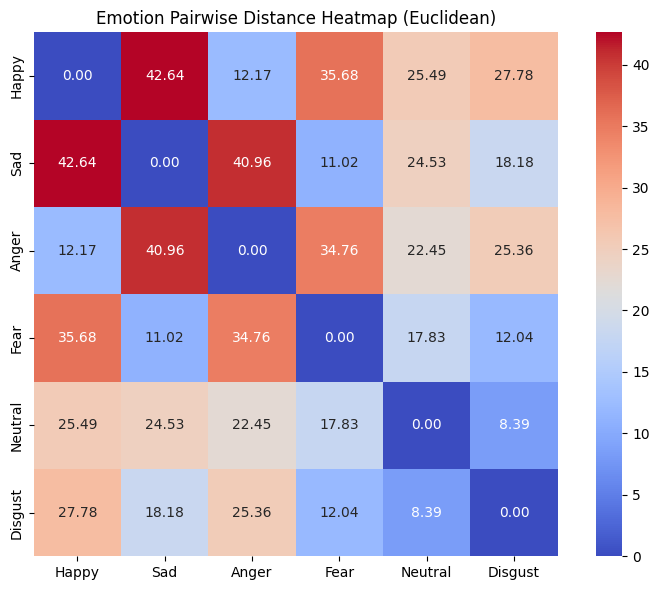

In [84]:
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

# Combine all feature group means into one emotion-level vector
combined_means = []

for emotion in emotions:
    all_values = []
    for group in feature_groups:
        all_values.extend(mean_feature_tables[group].loc[emotion].values)
    combined_means.append(all_values)

# Compute pairwise distances between emotions
distance_matrix = euclidean_distances(combined_means)

# Create a DataFrame for the heatmap
distance_df = pd.DataFrame(distance_matrix, index=emotions, columns=emotions)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Emotion Pairwise Distance Heatmap (Euclidean)")
plt.tight_layout()
plt.show()

This heatmap visualizes how dissimilar each pair of emotions is based on their average audio feature profiles (MFCC, Mel, Chroma, Spectral Contrast, Tonnetz). The distances are computed using Euclidean distance — lower values indicate greater similarity.


Most Similar Emotion Pairs (Lowest Distance):

Sad & Neutral:
These two emotions show the closest proximity. Both are low-arousal, flat-toned, and tend to have low energy across MFCC and Mel features. This reflects their similar acoustic profiles — calm, steady, and emotionally subdued.

Fear & Anger:
Despite being different in emotional context, both emotions share high-arousal, high-energy traits. Their MFCC, Mel, and Spectral Contrast values are elevated, leading to a smaller distance between them.

Most Dissimilar Emotion Pairs (Highest Distance):

Anger & Sad:
These emotions represent opposite ends of the vocal spectrum:

Anger → sharp, loud, high contrast

Sad → soft, monotone, low energy
This extreme contrast results in one of the highest distances on the matrix.

Fear & Neutral:
Fear is characterized by instability and vocal tension, while Neutral is steady and even-toned — leading to substantial divergence in features like Tonnetz and Mel.